In [9]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from intrinsic_ipd import IPDReader, IPDCamera, IPDImage, IPDLightCondition, CameraFramework
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pprint import pprint
np.set_printoptions(suppress=True, precision=16)
import itertools

In [11]:
import logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format="%(asctime)s - %(name)s - %(levelname)s - %(filename)s - %(funcName)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# Reading, Matching, and Evaluating Predictions all Datasets

In [12]:
from intrinsic_ipd.constants import DATASET_IDS
from intrinsic_ipd.evaluator import Evaluator
from intrinsic_ipd.utils import DisableLogger

In [13]:
DATASET_IDS

['dataset_basket_0',
 'dataset_basket_1',
 'dataset_basket_2',
 'dataset_basket_3',
 'dataset_basket_4',
 'dataset_basket_5',
 'dataset_basket_6',
 'dataset_basket_7',
 'dataset_basket_8',
 'dataset_basket_9',
 'dataset_darkbg_0',
 'dataset_darkbg_1',
 'dataset_darkbg_2',
 'dataset_darkbg_3',
 'dataset_darkbg_4',
 'dataset_darkbg_5',
 'dataset_darkbg_6',
 'dataset_darkbg_7',
 'dataset_darkbg_8',
 'dataset_texturedbg_0',
 'dataset_texturedbg_1',
 'dataset_texturedbg_2',
 'dataset_texturedbg_3']

In [16]:
import yaml
import numpy as np
from intrinsic_ipd.matcher import PoseMatcher

def get_foundation_pose_result(reader:IPDReader) -> PoseMatcher:
    matcher = PoseMatcher(reader, ordered=False)
    dataset_id = reader.dataset_id
    file = f"./results/{dataset_id}_PHOTONEO.yml"
    if not os.path.exists(file):
        return False
    # file = "../FoundationPose/debug/ipd/dataset_darkbg_0_PHOTONEO.yml"
    with open(file) as stream:
        poses_by_part_by_scene = yaml.safe_load(stream)
    poses_by_object_by_scene = {}
    for scene in poses_by_part_by_scene:
        poses_by_part = poses_by_part_by_scene[scene]
        poses_by_object_by_scene[scene] = {}
        for part in poses_by_part:
            poses = poses_by_part[part] #dict
            poses = [poses[key] for key in sorted(poses.keys(), reverse=False)] #sorted values
            poses = np.array(poses)
            poses[:,:3, 3] *= 1e3
            matcher.register_poses(scene, part, poses, mode="override")
    return matcher

In [17]:
readers = {}
ordered_preds = {}
consistency = {}
accuracy = {}
matchers = {}
datasets  = []
for dataset_id in DATASET_IDS:
    with DisableLogger():
        reader = IPDReader("./datasets", dataset_id, IPDCamera.PHOTONEO, lighting=IPDLightCondition.ROOM, download=True) 
        evaluator = Evaluator(reader)
        matcher = get_foundation_pose_result(reader)
    if matcher:
        datasets += [dataset_id]
        ordered_pred = matcher.get_matched_poses()
        consistency[dataset_id] = evaluator.measure_robot_consistency(ordered_pred)
        accuracy[dataset_id] = evaluator.measure_ground_truth_accuracy(ordered_pred)
        readers[dataset_id] = reader
        ordered_preds[dataset_id] = ordered_pred
        matchers[dataset_id] = matcher

/home/carynt/ipd/src/intrinsic_ipd/utils.py:311: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eulers = R.from_matrix(poses[:, :3, :3]).as_euler(removal_axes)
/home/carynt/ipd/src/intrinsic_ipd/utils.py:311: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eulers = R.from_matrix(poses[:, :3, :3]).as_euler(removal_axes)
/home/carynt/ipd/src/intrinsic_ipd/utils.py:311: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eulers = R.from_matrix(poses[:, :3, :3]).as_euler(removal_axes)
/home/carynt/ipd/src/intrinsic_ipd/utils.py:311: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eulers = R.from_matrix(poses[:, :3, :3]).as_euler(removal_axes)
/home/carynt/ipd/src/intrinsic_ipd/utils.py:311: Use

In [19]:
#datasets with results!
datasets

['dataset_basket_0',
 'dataset_basket_1',
 'dataset_basket_2',
 'dataset_basket_3',
 'dataset_basket_4',
 'dataset_basket_5',
 'dataset_basket_6',
 'dataset_basket_7',
 'dataset_basket_8',
 'dataset_basket_9',
 'dataset_darkbg_0',
 'dataset_darkbg_1',
 'dataset_darkbg_2',
 'dataset_darkbg_3',
 'dataset_darkbg_4',
 'dataset_darkbg_5',
 'dataset_darkbg_6',
 'dataset_darkbg_7',
 'dataset_darkbg_8',
 'dataset_texturedbg_0',
 'dataset_texturedbg_1',
 'dataset_texturedbg_2',
 'dataset_texturedbg_3']

# Rendering scenes from a dataset

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from intrinsic_ipd.render import render_scene
import cv2

2024-09-18 07:02:23 - OpenGL.acceleratesupport - INFO - acceleratesupport.py - <module> - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [21]:
dataset_id = datasets[5]
print(dataset_id)


dataset_basket_5


In [22]:
ordered_pred = ordered_preds[dataset_id]
reader = readers[dataset_id]

In [90]:
consistency[dataset_id].to_pandas()

part          instance
oblong_float  0           125.438037
              1           103.112536
              2            92.683981
dtype: float64

In [22]:
accuracy[dataset_id].to_pandas()

part          instance
oblong_float  0           32.808348
              1           32.318147
              2           53.851806
dtype: float64

In [24]:
matchers[dataset_id].get_counts().to_pandas()

part,corner_bracket5,oblong_float
counts,,
true_positive,0,88
test_positive,0,90
actual_positive,30,90


In [14]:
scenes = np.linspace(30, 59, 5).astype(int)
overlays = []
images = []
renders = []
gt_renders = []
for scene in scenes:
    image, rendered_image, overlay = render_scene(reader, scene, poses=ordered_pred)
    _ , gt_rendered_image, _ = render_scene(reader, scene)
    alpha = 0.1  # Transparency of the overlay
    overlay = cv2.addWeighted(image, 1 - alpha, rendered_image, alpha, 0)
    overlays.append(overlay)
    images.append(image)
    renders.append(rendered_image)
    gt_renders.append(gt_rendered_image)

2024-08-28 23:16:44 - root - WARNING - render.py - render_scene - Set PYOPENGL_PLATFORM environment variable before importing pyrender or any other OpenGL library. 
	Setting to PYOPENGL_PLATFORM=`egl`. 
	See https://pyrender.readthedocs.io/en/latest/examples/offscreen.html 
2024-08-28 23:16:44 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_basket_5/test/000030/000/rgb/000000.png


2024-08-28 23:16:45 - root - WARNING - render.py - render_scene - No mesh found for corner_bracket5, skipping part render
2024-08-28 23:16:45 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_basket_5/test/000030/000/rgb/000000.png
2024-08-28 23:16:45 - root - WARNING - render.py - render_scene - No mesh found for corner_bracket5, skipping part render
2024-08-28 23:16:46 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_basket_5/test/000037/000/rgb/000000.png
2024-08-28 23:16:46 - root - WARNING - render.py - render_scene - No mesh found for corner_bracket5, skipping part render
2024-08-28 23:16:46 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_basket_5/test/000037/000/rgb/000000.png
2024-08-28 23:16:46 - root - WARNING - render.py - render_scene - No mesh found for corner_bracket5, skipping part render
2024-08-28 23:16:47 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_basket_5

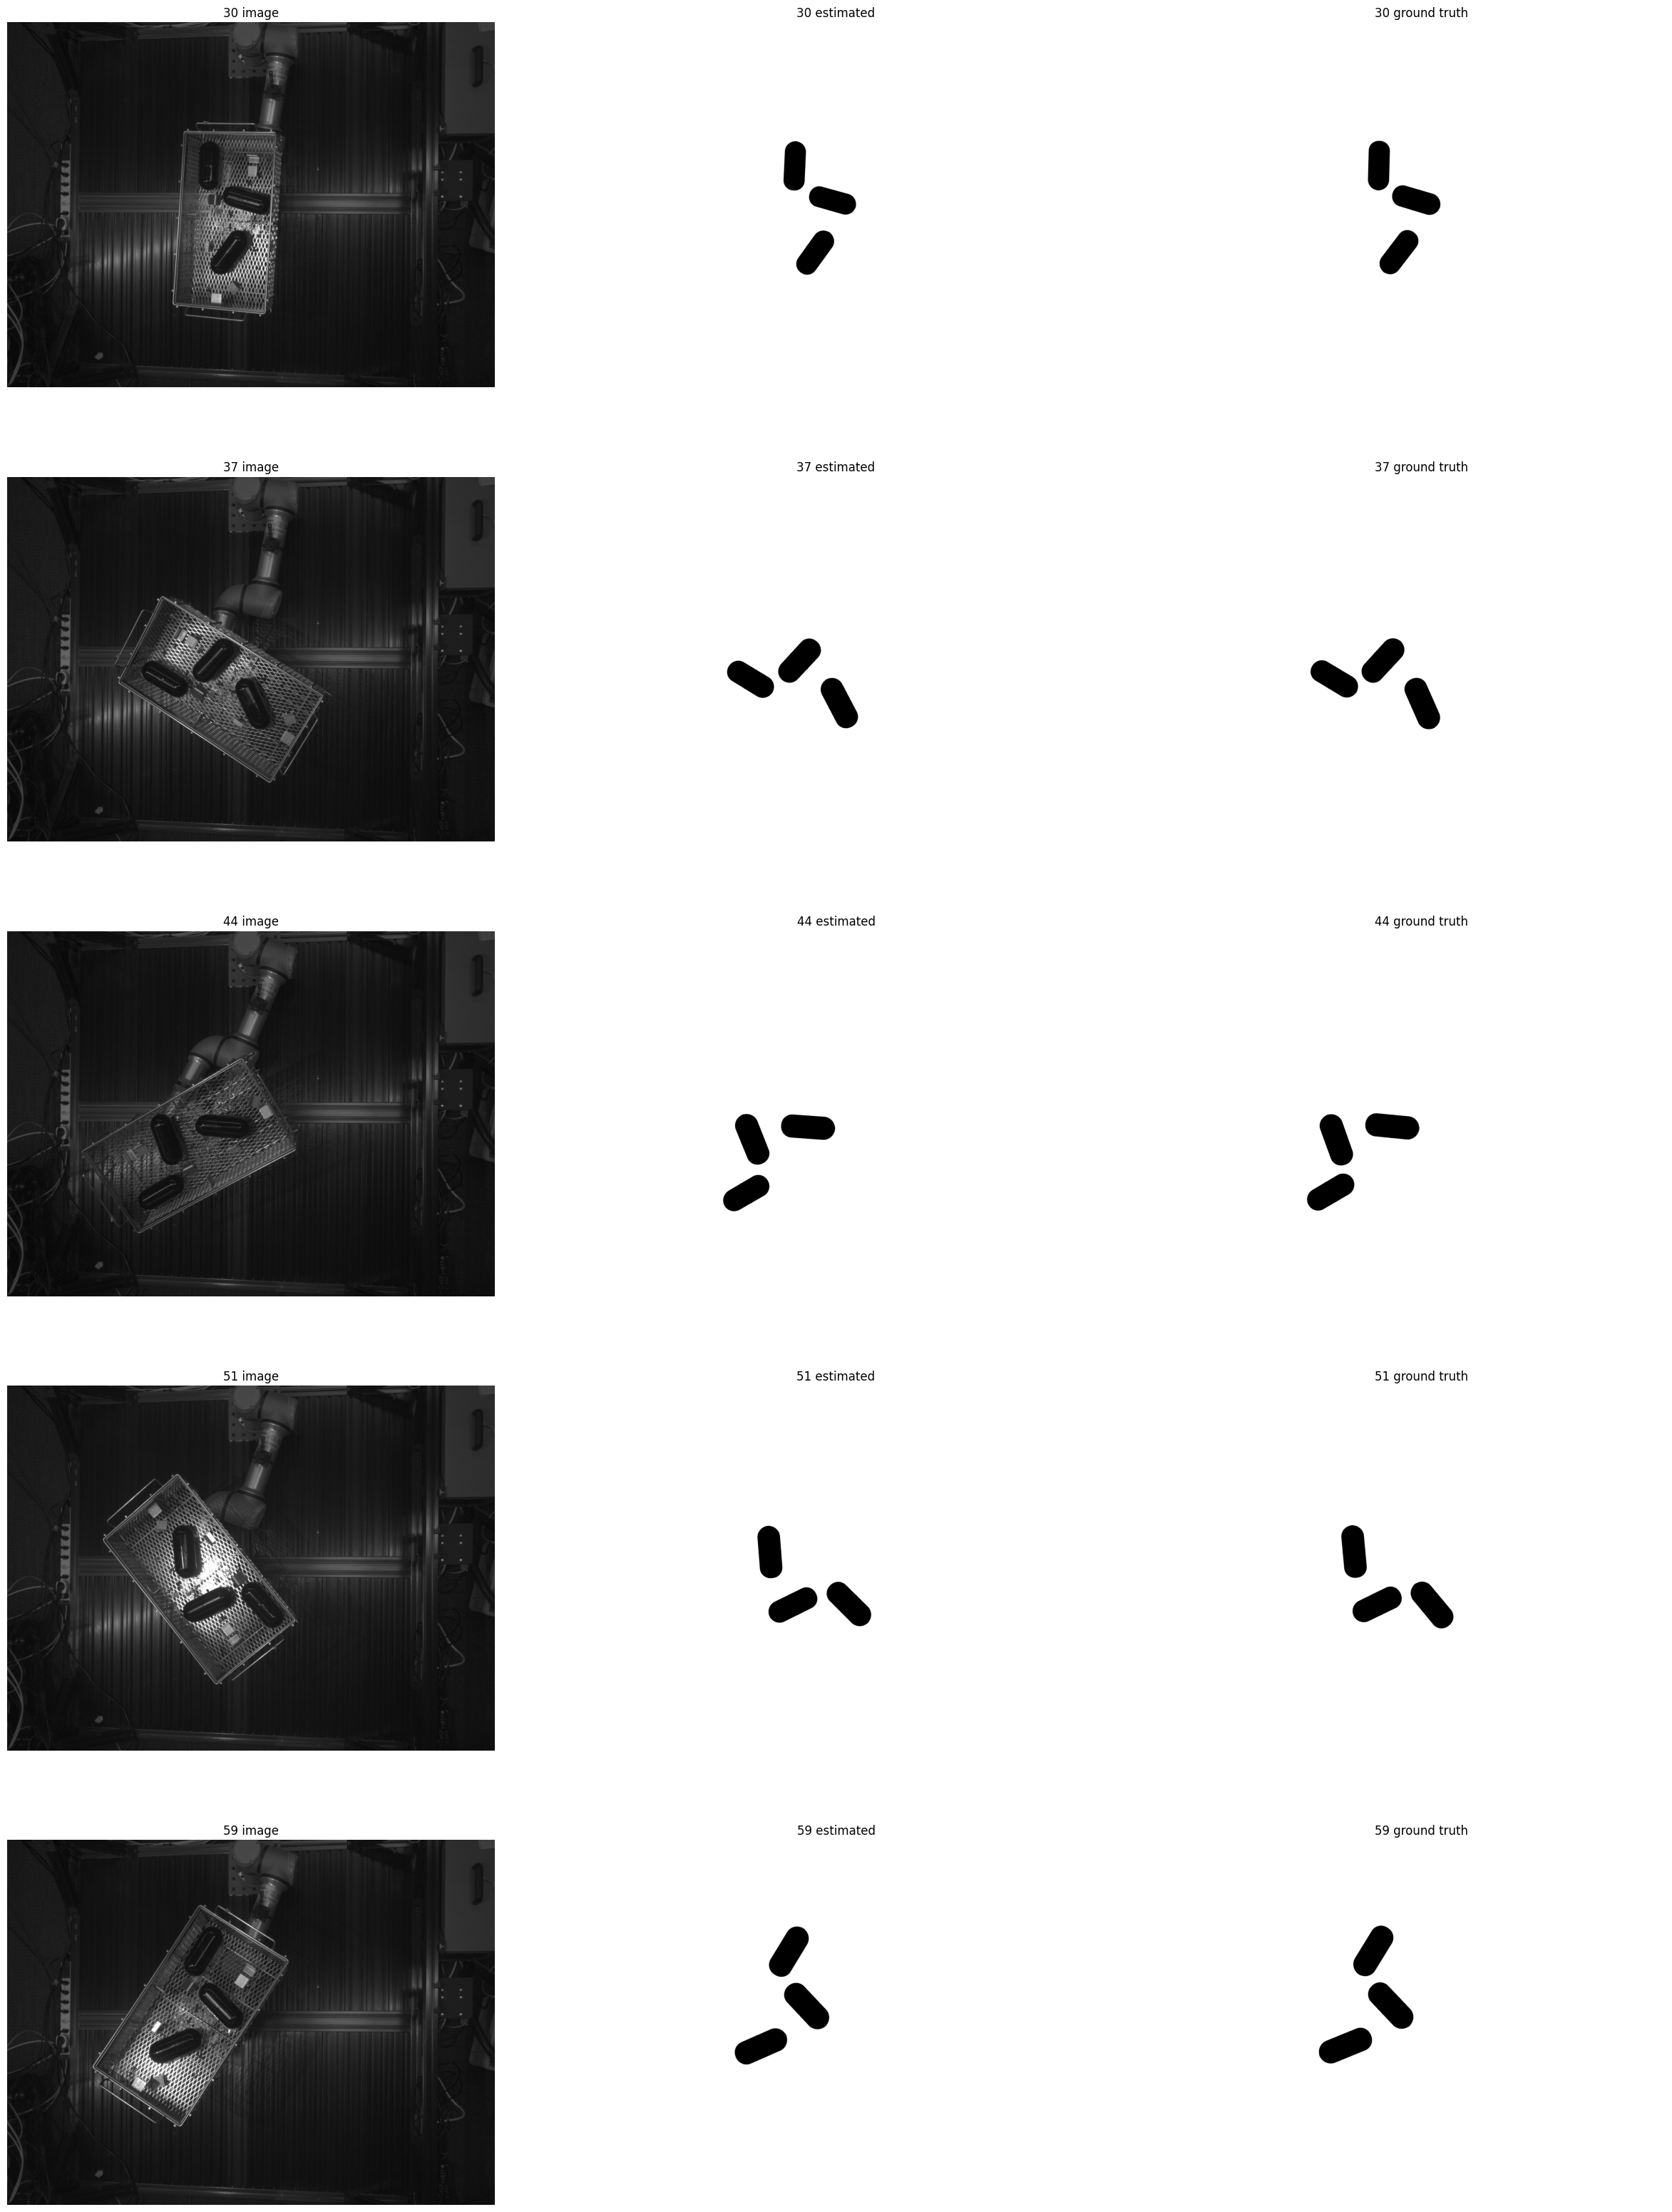

In [15]:
rows = len(scenes)
width = 10
height = int(.8 * width)
fig = plt.figure(figsize=(width*3, height*rows))
for i, scene_views in enumerate(zip(scenes, zip(images, renders, gt_renders))):
    scene, views = scene_views
    titles = ["image", "estimated", "ground truth"]
    for j, view in enumerate(views):
        plt.subplot(rows,3,i*3+j+1)
        plt.title(str(scene)+" "+titles[j])
        plt.axis('off')
        plt.imshow(view)

# Aggregating Statistics by part across all datasets

In [23]:
def median(x):
    return x.median()

def p70(x):
    return np.percentile(x, 70)

def p90(x):
    return np.percentile(x, 90)

def p99(x):
    return np.percentile(x, 99)


In [24]:
dataset_consistencies_df = pd.concat([c.to_pandas() for c in consistency.values()])
dataset_accuracies_df = pd.concat([a.to_pandas() for a in accuracy.values()])

part_consistencies_df = dataset_consistencies_df.groupby("part").agg(['count', 'median', p70, p90, p99])
part_accuracies_df = dataset_accuracies_df.groupby("part").agg(['count', 'median', p70, p90, p99])

In [25]:
part_consistencies_df

,count,median,p70,p90,p99
part,,,,,
corner_bracket,12,2.728799,7.571522,17.774647,33.737956
corner_bracket0,13,2.402788,2.764084,3.020772,3.441349
corner_bracket1,24,3.646409,5.892022,11.623335,15.167667
corner_bracket2,13,27.463298,27.913292,29.785043,31.891592
corner_bracket3,16,1.978342,2.183848,6.761002,23.737888
corner_bracket4,16,2.538188,6.723240,21.413624,35.182042
corner_bracket6,20,5.776719,10.483117,10.953437,19.318581
gear1,12,1.559180,1.648257,1.932636,6.772314
gear2,15,1.305575,1.364975,1.549020,1.671275


In [26]:
part_accuracies_df

,count,median,p70,p90,p99
part,,,,,
corner_bracket,12,2.896244,7.460481,14.643827,23.433105
corner_bracket0,13,3.317204,3.656040,5.139397,5.315028
corner_bracket1,24,4.527361,5.566918,9.544451,18.371894
corner_bracket2,13,33.431267,37.492445,40.074082,46.760136
corner_bracket3,16,3.644011,5.837399,11.435435,22.203626
corner_bracket4,16,5.649924,6.498774,15.412030,33.333685
corner_bracket6,20,6.050998,7.035136,10.378214,17.836049
gear1,12,4.718994,5.037672,5.249381,8.316372
gear2,15,4.309647,4.467950,4.646685,4.762003


In [27]:
## CALCULATE PRECISION AND RECALL WITH XARRAY

# all_counts = xr.concat([matchers[i].get_counts() for i in matchers], dim="dataset", fill_value = 0).stack(dataset_part=["dataset", "part"])
# counts_by_part = all_counts.groupby("part").sum()
# precision = (counts_by_part.loc['true_positive'] / counts_by_part.loc['test_positive'])
# recall = (counts_by_part.loc['true_positive'] / counts_by_part.loc['actual_positive'])

In [28]:
## CALCULATE PRECISION AND RECALL WITH PANDAS

all_counts = pd.concat([matchers[i].get_counts().to_pandas().T for i in matchers])    
counts_by_part  = all_counts.groupby("part").sum()
stats = pd.DataFrame()
stats['precision'] = counts_by_part['true_positive'] / counts_by_part['test_positive']
stats['recall'] = counts_by_part['true_positive'] / counts_by_part['actual_positive']


In [29]:
pd.merge(part_accuracies_df, stats, on='part', how='outer')
pd.merge(part_consistencies_df, stats, on='part', how='outer')

,count,median,p70,p90,p99,precision,recall
part,,,,,,,
corner_bracket,12.0,2.728799,7.571522,17.774647,33.737956,0.975000,0.975000
corner_bracket0,13.0,2.402788,2.764084,3.020772,3.441349,0.753846,0.753846
corner_bracket1,24.0,3.646409,5.892022,11.623335,15.167667,0.855556,0.855556
corner_bracket2,13.0,27.463298,27.913292,29.785043,31.891592,0.997436,0.997436
corner_bracket3,16.0,1.978342,2.183848,6.761002,23.737888,0.964583,0.964583
corner_bracket4,16.0,2.538188,6.723240,21.413624,35.182042,0.697917,0.697917
corner_bracket6,20.0,5.776719,10.483117,10.953437,19.318581,0.983333,0.983333
gear1,12.0,1.559180,1.648257,1.932636,6.772314,1.000000,1.000000
gear2,15.0,1.305575,1.364975,1.549020,1.671275,0.993333,0.993333
